#### Курсовой проект по по курсу "Python для Data Science"

#### Cлушатель: Перфильев Дмитрий

#### Задание:

Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

Целевая переменная:
Price

Основная метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Вспомогательная метрика:
MSE - средняя квадратичная ошибка (sklearn.metrics.mean_squared_error)

Сдача проекта:
1. Прислать в раздел Задания Урока 12 ("Вебинар. Консультация по итоговому проекту")
ссылку на программу в github (программа должна содержаться в файле Jupyter Notebook 
с расширением ipynb).
2. Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).

Сроки сдачи:
Сдать проект за 72 часа до начала Урока 13 ("Вебинар. Результаты итоговых проектов и закрытие курса").

Примечание:
Все файлы csv должны содержать названия полей (header - то есть "шапку"),
разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.


#### Решение:

##### Загружаем необходимые библиотеки. Устанавливаем настройки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as tts

style.use('fivethirtyeight')
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

##### Загрузим данные из файла data_train.csv по которым построим модель. 

In [2]:
data_train = pd.read_csv('DATA/train.csv', sep=',')
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


##### Вспомагательные функции

In [3]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

def k_min(data):
    return data['Square'].mean() / (data['Rooms'].mean() + data['Rooms'].std())

def k_max(data):
    return data['Square'].mean() / (data['Rooms'].mean() - data['Rooms'].std())

def create_model(X_train, y_train, X_test, y_test, feats, model):
    model.fit(X_train.loc[:, feats], y_train)
    y_pred = model.predict(X_test.loc[:, feats])
    mse_rate = mean_squared_error(y_test, y_pred)
    r2_rate = r2(y_test, y_pred)
    return {'mse':  mse_rate, 'r2': r2_rate}


In [4]:
def mean_group(data,name_col):
    return data.loc[data[name_col],name_col].mean()

In [5]:
def ratio(x, y):
    if y == 0:
        return print(f'Делитель = 0')
    return x / y

##### Оценим качество данных. Произведем первичную обработку данных.

##### Оценим количество отсутствующих полей

In [6]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
Id               10000 non-null int64
DistrictId       10000 non-null int64
Rooms            10000 non-null float64
Square           10000 non-null float64
LifeSquare       7887 non-null float64
KitchenSquare    10000 non-null float64
Floor            10000 non-null int64
HouseFloor       10000 non-null float64
HouseYear        10000 non-null int64
Ecology_1        10000 non-null float64
Ecology_2        10000 non-null object
Ecology_3        10000 non-null object
Social_1         10000 non-null int64
Social_2         10000 non-null int64
Social_3         10000 non-null int64
Healthcare_1     5202 non-null float64
Helthcare_2      10000 non-null int64
Shops_1          10000 non-null int64
Shops_2          10000 non-null object
Price            10000 non-null float64
dtypes: float64(8), int64(9), object(3)
memory usage: 1.5+ MB


##### Поле Healthcare_1 имеет значительное количество пропущенных полей почти половины от общего числа (3666 из 7000) имеет смысл удалить данный признак из данных. Если модель без данного признака не будет показывать положительных результатов постараемся восстановить денный признак.

In [7]:
data_train = data_train.drop('Healthcare_1', axis=1)

In [8]:
data_train.shape

(10000, 19)

In [9]:
data_train['DistrictId'].unique().shape[0]

205

##### Преобразуем категориальные признаки Ecology_2 Ecology_3  

In [10]:
data_train['Ecology_2'].value_counts()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [11]:
data_train['Ecology_2'] = (data_train['Ecology_2'] == 'B').astype(int)

In [12]:
data_train['Ecology_3'].value_counts()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [13]:
data_train['Ecology_3'] = (data_train['Ecology_3'] == 'B').astype(int)

In [14]:
data_train['Shops_2'].value_counts()

B    9175
A     825
Name: Shops_2, dtype: int64

In [15]:
data_train['Shops_2'] = (data_train['Shops_2'] == 'B').astype(int)

In [16]:
data_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,1,1,33,7976,5,0,11,1,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,1,1,46,10309,1,1,16,1,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,1,1,34,7759,0,1,3,1,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,1,1,23,5735,3,0,5,1,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,1,1,35,5776,1,2,4,1,150226.531644


In [17]:
data_train.shape

(10000, 19)

##### Найдем аномалии в данных в столбще HouseYear. Преобразуем данные HouseYear - вычислим возраст домов. 


In [18]:
data_train.loc[2020 - data_train['HouseYear'] < 0,'HouseYear']

1497    20052011
4189        4968
Name: HouseYear, dtype: int64

In [19]:
data_train.loc[data_train['HouseYear'] == 20052011,'HouseYear'] = 2011
data_train.loc[data_train['HouseYear'] == 4968,'HouseYear'] = 1968

In [20]:
data_train.loc[2019 - data_train['HouseYear'] < 0,'HouseYear']

585     2020
707     2020
790     2020
918     2020
1499    2020
2493    2020
2877    2020
3357    2020
3485    2020
3859    2020
4053    2020
4376    2020
4493    2020
5701    2020
6735    2020
7076    2020
7459    2020
8253    2020
9674    2020
Name: HouseYear, dtype: int64

In [21]:
data_train.loc[2019 - data_train['HouseYear'] > 100,'HouseYear']

910     1914
1380    1917
1386    1918
2554    1918
2656    1912
2902    1918
5016    1918
5053    1917
5111    1912
7611    1916
8144    1917
8505    1918
9317    1910
Name: HouseYear, dtype: int64

In [22]:
data_train['HouseYear'] = 2020 - data_train['HouseYear']

In [23]:
data_train['HouseYear'].describe()

count    10000.000000
mean        35.133700
std         18.412271
min          0.000000
25%         19.000000
50%         43.000000
75%         46.000000
max        110.000000
Name: HouseYear, dtype: float64

##### Оценим данные Price

In [24]:
data_train['Price'].describe()

count     10000.000000
mean     214138.857399
std       92872.293865
min       59174.778028
25%      153872.633942
50%      192269.644879
75%      249135.462171
max      633233.466570
Name: Price, dtype: float64

In [25]:
data_train.loc[data_train['Price'] > 600000,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
1537,3206,54,3.0,125.117838,NaN,1.0,4,1.0,43,0.006076,1,1,30,5285,0,6,6,1,625820.041178
2442,13532,146,3.0,106.246398,64.451747,14.0,9,18.0,10,0.236108,1,1,16,3893,27,3,10,1,616857.135464
2857,3876,100,4.0,104.769022,79.316650,8.0,4,8.0,60,0.200147,1,1,23,3975,8,2,0,1,600903.828562
3228,15192,26,3.0,117.714551,57.440648,15.0,17,30.0,8,0.000000,1,1,36,6714,2,0,2,1,624680.099059
3305,15749,66,3.0,78.747853,33.885760,11.0,2,5.0,65,0.161976,1,0,31,7010,5,3,7,1,606958.937510
3890,9840,108,3.0,78.824038,53.016323,8.0,2,8.0,62,0.000000,1,1,23,3684,2,0,4,1,611542.063430
3937,6808,146,3.0,106.867638,64.341756,14.0,4,22.0,9,0.236108,1,1,16,3893,27,3,10,1,610557.405615
4487,13434,13,5.0,183.382273,100.985505,15.0,2,6.0,23,0.090799,1,1,74,19083,2,5,15,1,622888.825328
4764,11013,43,2.0,58.757047,34.605286,8.0,12,17.0,16,0.000078,1,1,22,6398,141,3,23,1,625678.644994
5494,300,31,2.0,106.427686,34.230415,32.0,4,40.0,7,0.151346,1,0,32,5889,10,4,1,1,624549.354546


In [26]:
data_train.loc[data_train['Price'] < 60000,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
3605,7243,9,2.0,58.089253,52.460857,8.0,5,22.0,39,0.136244,1,1,11,2370,0,0,1,1,59877.592523
9732,13237,144,2.0,51.726692,30.547287,8.0,2,14.0,32,0.306977,1,1,27,5148,14,5,7,1,59174.778028


##### Оценим данные Rooms

In [27]:
data_train['Rooms'].describe()

count    10000.000000
mean         1.890500
std          0.839512
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max         19.000000
Name: Rooms, dtype: float64

In [28]:
data_train.loc[(data_train['Rooms'] < 1) & (data_train['HouseYear'] > 20),:].index

Int64Index([2269, 4366, 4853, 6149, 8834], dtype='int64')

In [29]:
arr_index = data_train.loc[(data_train['Rooms'] < 1) & (data_train['HouseYear'] > 20),:].index

In [30]:
for item in arr_index:
    data_train.loc[item,"Rooms"] = round(data_train.loc[(data_train.loc[item,"Square"] - 5  < data_train["Square"]) & 
                                                        (data_train["Square"] <  data_train.loc[item,"Square"] + 5) & 
                                                        (data_train["HouseYear"] == data_train.loc[item, "HouseYear"]),"Rooms"].mean())

In [31]:
data_train.loc[arr_index,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
2269,7317,27,1.0,41.790881,NaN,0.0,13,0.0,43,0.211401,1,1,9,1892,0,0,1,1,98129.976788
4366,456,6,3.0,81.491446,NaN,0.0,4,0.0,43,0.243205,1,1,5,1564,0,0,0,1,212864.799112
4853,3224,27,1.0,2.377248,0.873147,0.0,1,0.0,43,0.017647,1,1,2,469,0,0,0,1,126596.941798
6149,3159,88,1.0,38.697117,19.345131,9.0,9,16.0,38,0.127376,1,1,43,8429,3,3,9,1,158998.110646
8834,9443,27,3.0,87.762616,85.125471,0.0,5,15.0,43,0.211401,1,1,9,1892,0,0,1,1,219281.918007


In [32]:
data_train.loc[data_train['Rooms'] >= 6,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
377,5927,57,10.0,59.056975,36.223072,10.0,22,22.0,18,0.090799,1,1,74,19083,2,5,15,1,317265.323792
1454,8491,1,19.0,42.006046,21.779288,7.0,17,17.0,6,0.007122,1,1,1,264,0,0,1,1,78364.616704
2170,14003,99,6.0,59.414334,38.702244,6.0,7,9.0,51,0.033494,1,1,66,10573,1,3,8,1,229661.964416
8849,14865,9,10.0,60.871266,38.420681,10.0,3,2.0,26,0.161532,1,1,25,5648,1,2,4,1,172329.270863


In [33]:
data_train.loc[data_train['Rooms'] >= 6,'Rooms'] = 1

In [34]:
data_train['Rooms'].describe()

count    10000.000000
mean         1.887300
std          0.812197
min          0.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          5.000000
Name: Rooms, dtype: float64

##### Оценим данные в колнках  Square LifeSquare

In [35]:
data_train[['Square','LifeSquare']].describe()

,Square,LifeSquare
count,10000.000000,7887.000000
mean,56.315775,37.199645
std,21.058732,86.241209
min,1.136859,0.370619
25%,41.774881,22.769832
50%,52.513310,32.781260
75%,65.900625,45.128803
max,641.065193,7480.592129


In [36]:
k_min = k_min(data_train)
k_max = k_max(data_train) 
k_min, k_max

(20.86157757686592, 52.38177000925879)

In [37]:
arr_index = data_train.loc[data_train['Square'] < data_train['Rooms'] * k_min/1.5,:].index

In [38]:
data_train.loc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
212,1748,88,2.0,5.497061,67.628717,1.0,24,22.0,43,0.127376,1,1,43,8429,3,3,9,1,412511.088764
1316,11526,27,1.0,4.633498,1.969969,1.0,18,1.0,43,0.011654,1,1,4,915,0,0,0,1,107604.269441
1608,10202,6,1.0,2.596351,4.604943,1.0,3,25.0,6,0.243205,1,1,5,1564,0,0,0,1,137597.601458
2247,16772,109,3.0,32.795221,36.659413,6.0,2,9.0,41,0.136330,1,1,30,6141,10,3,6,1,173602.708629
3271,6358,27,5.0,42.003293,NaN,0.0,5,12.0,43,0.011654,1,1,4,915,0,0,0,1,112693.641769
3280,10527,27,1.0,4.380726,40.805837,1.0,10,17.0,7,0.211401,1,1,9,1892,0,0,1,1,97560.720383
3413,9487,5,1.0,5.129222,5.549458,1.0,1,1.0,43,0.150818,1,1,16,3433,4,4,5,1,369472.403061
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,43,0.049637,1,1,34,7759,0,1,3,1,206148.845716
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,60,0.319809,1,1,25,4756,16,5,8,1,78388.806186
4853,3224,27,1.0,2.377248,0.873147,0.0,1,0.0,43,0.017647,1,1,2,469,0,0,0,1,126596.941798


In [39]:
data_train.loc[data_train['Square'] < 10 ,'Square'] = data_train['Rooms'] * data_train['Square'].mean()

In [40]:
arr_index = data_train.loc[data_train['Square'] < data_train['Rooms'] * k_min/1.5,:].index

In [41]:
data_train.loc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
2247,16772,109,3.0,32.795221,36.659413,6.0,2,9.0,41,0.136330,1,1,30,6141,10,3,6,1,173602.708629
3271,6358,27,5.0,42.003293,NaN,0.0,5,12.0,43,0.011654,1,1,4,915,0,0,0,1,112693.641769
4431,7594,53,5.0,39.906082,39.394024,1.0,5,1.0,43,0.049637,1,1,34,7759,0,1,3,1,206148.845716
4739,12676,81,3.0,13.784865,15.988889,7.0,4,5.0,60,0.319809,1,1,25,4756,16,5,8,1,78388.806186
5155,1392,30,3.0,39.596076,41.832097,0.0,2,5.0,43,0.000078,1,1,22,6398,141,3,23,1,147861.195616
5617,15877,57,3.0,16.547242,16.698571,8.0,5,5.0,58,0.133215,1,1,49,11395,3,3,4,0,77835.185808
6945,12927,62,2.0,17.414181,NaN,1.0,4,20.0,43,0.072158,1,1,2,629,1,0,0,0,180750.471749
8148,3052,1,3.0,31.113950,19.799743,6.0,6,5.0,45,0.014581,1,1,3,760,1,0,0,1,114756.610121
8551,13772,96,4.0,44.128947,18.212628,10.0,10,13.0,15,0.041116,1,1,53,14892,4,1,4,1,201374.604049


In [42]:
for index in arr_index:
    rooms = round(data_train.loc[index,'Square']/data_train['Square'].mean())
    if rooms == 0:
        rooms = 1
    data_train.loc[index,'Rooms'] = rooms

In [43]:
data_train.loc[arr_index]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
2247,16772,109,1.0,32.795221,36.659413,6.0,2,9.0,41,0.136330,1,1,30,6141,10,3,6,1,173602.708629
3271,6358,27,1.0,42.003293,NaN,0.0,5,12.0,43,0.011654,1,1,4,915,0,0,0,1,112693.641769
4431,7594,53,1.0,39.906082,39.394024,1.0,5,1.0,43,0.049637,1,1,34,7759,0,1,3,1,206148.845716
4739,12676,81,1.0,13.784865,15.988889,7.0,4,5.0,60,0.319809,1,1,25,4756,16,5,8,1,78388.806186
5155,1392,30,1.0,39.596076,41.832097,0.0,2,5.0,43,0.000078,1,1,22,6398,141,3,23,1,147861.195616
5617,15877,57,1.0,16.547242,16.698571,8.0,5,5.0,58,0.133215,1,1,49,11395,3,3,4,0,77835.185808
6945,12927,62,1.0,17.414181,NaN,1.0,4,20.0,43,0.072158,1,1,2,629,1,0,0,0,180750.471749
8148,3052,1,1.0,31.113950,19.799743,6.0,6,5.0,45,0.014581,1,1,3,760,1,0,0,1,114756.610121
8551,13772,96,1.0,44.128947,18.212628,10.0,10,13.0,15,0.041116,1,1,53,14892,4,1,4,1,201374.604049


In [44]:
data_train[['Square','LifeSquare']].describe()

,Square,LifeSquare
count,10000.000000,7887.000000
mean,56.407071,37.199645
std,21.047374,86.241209
min,13.784865,0.370619
25%,41.794392,22.769832
50%,52.571358,32.781260
75%,65.925548,45.128803
max,641.065193,7480.592129


In [45]:
arr_index = data_train.loc[data_train['Square'] > data_train['Rooms'] * k_max * 2,:].index
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
506,9552,23,1.0,105.432181,106.178175,0.0,3,2.0,43,0.014073,1,1,2,475,0,0,0,1,218718.046451
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,4,0.075424,1,1,11,3097,0,0,0,1,268394.744389
1641,11055,151,1.0,174.649522,174.837082,15.0,10,12.0,62,0.236108,1,1,16,3893,27,3,10,1,232766.187698
1918,13603,63,1.0,127.651237,2.609712,1.0,8,17.0,4,0.238617,1,1,26,3889,6,3,6,1,594565.299770
1956,15157,54,1.0,106.239622,83.296167,17.0,26,37.0,11,0.006076,1,1,30,5285,0,6,6,1,274139.065875


In [46]:
for index in arr_index:
    if (data_train.loc[index,'Square'] > 200) & (data_train.loc[index,'Rooms'] < 3) & (data_train.loc[index,'Rooms'] != 0):
        data_train.loc[index,'Square'] = data_train.loc[index,'Rooms'] * data_train['Square'].mean()
        continue
    if ((data_train.loc[index,'Square'] < 200) & (data_train.loc[index,'Rooms'] < 3)) | (data_train.loc[index,'Rooms'] == 0):
        data_train.loc[index,'Rooms'] = round(data_train.loc[index,'Square']/k_max)
        continue

In [47]:
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
506,9552,23,2.0,105.432181,106.178175,0.0,3,2.0,43,0.014073,1,1,2,475,0,0,0,1,218718.046451
1397,12638,27,3.0,138.427694,136.215499,0.0,4,3.0,4,0.075424,1,1,11,3097,0,0,0,1,268394.744389
1641,11055,151,3.0,174.649522,174.837082,15.0,10,12.0,62,0.236108,1,1,16,3893,27,3,10,1,232766.187698
1918,13603,63,2.0,127.651237,2.609712,1.0,8,17.0,4,0.238617,1,1,26,3889,6,3,6,1,594565.299770
1956,15157,54,2.0,106.239622,83.296167,17.0,26,37.0,11,0.006076,1,1,30,5285,0,6,6,1,274139.065875


In [48]:
data_train[['Square','LifeSquare']].describe()

,Square,LifeSquare
count,10000.000000,7887.000000
mean,56.269733,37.199645
std,19.154426,86.241209
min,13.784865,0.370619
25%,41.794392,22.769832
50%,52.571358,32.781260
75%,65.912854,45.128803
max,275.645284,7480.592129


In [49]:
data_train.loc[data_train['Square'] > data_train['Rooms'] * k_max * 2,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price


In [50]:
data_train['LifeSquare'] = data_train['LifeSquare'].fillna(data_train['Square']*0.9)

In [51]:
data_train.loc[data_train['LifeSquare'] > data_train['Rooms'] * k_max * 2,:] 

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
590,14990,23,2.0,48.449873,263.542020,5.0,6,5.0,48,0.075779,1,1,6,1437,3,0,2,1,141780.231857
4328,16550,27,3.0,81.694417,7480.592129,1.0,9,17.0,4,0.017647,1,1,2,469,0,0,0,1,217357.492366
4690,2307,102,1.0,56.357882,410.639749,10.0,4,4.0,4,0.238617,1,1,26,3889,6,3,6,1,90470.430830
6094,9021,23,1.0,103.744170,105.338395,1.0,26,25.0,43,0.075779,1,1,6,1437,3,0,2,1,223249.331500
6332,8961,27,1.0,33.398983,164.153360,6.0,3,5.0,55,0.211401,1,1,9,1892,0,0,1,1,104891.073757
6977,11602,30,2.0,112.645150,638.163193,10.0,20,19.0,1,0.000078,1,1,22,6398,141,3,23,1,133529.681562
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,22,0.037178,1,1,52,11217,1,1,7,1,394253.299978


In [52]:
data_train.loc[data_train['LifeSquare'] > data_train['Rooms'] * k_max * 2,'LifeSquare'] = data_train['Square']*0.95

In [53]:
data_train[['Square','LifeSquare']].describe()

,Square,LifeSquare
count,10000.000000,10000.000000
mean,56.269733,39.868826
std,19.154426,19.225151
min,13.784865,0.370619
25%,41.794392,25.470423
50%,52.571358,36.308777
75%,65.912854,48.903323
max,275.645284,233.949309


In [54]:
data_train.loc[data_train['LifeSquare'] < data_train['Rooms'] * k_min/1.5,'LifeSquare'] = data_train['Square']*0.95

In [55]:
arr_index = data_train.loc[data_train['LifeSquare'] > data_train['Square'],'Square'].index
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530043,43.967759,1.0,3,9.0,6,0.034656,1,1,0,168,0,0,0,1,95338.198549
44,10521,38,3.0,104.211396,106.340403,0.0,20,0.0,3,0.060753,1,1,15,2787,2,0,7,1,435462.048070
52,2301,1,2.0,61.400054,65.224603,0.0,17,22.0,4,0.007122,1,1,1,264,0,0,1,1,199215.452229
123,8753,25,3.0,85.952306,89.803753,1.0,4,3.0,3,0.069753,1,1,53,13670,4,1,11,1,309688.592681
153,9870,62,1.0,51.831473,53.491301,1.0,5,1.0,5,0.072158,1,1,2,629,1,0,0,0,131797.472284


In [56]:
df_square = data_train.loc[arr_index,'Square'].copy()
data_train.loc[arr_index,'Square'] = data_train.loc[arr_index,'LifeSquare']
data_train.loc[arr_index,'LifeSquare'] = df_square

In [57]:
data_train.loc[arr_index].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,43.967759,42.530043,1.0,3,9.0,6,0.034656,1,1,0,168,0,0,0,1,95338.198549
44,10521,38,3.0,106.340403,104.211396,0.0,20,0.0,3,0.060753,1,1,15,2787,2,0,7,1,435462.048070
52,2301,1,2.0,65.224603,61.400054,0.0,17,22.0,4,0.007122,1,1,1,264,0,0,1,1,199215.452229
123,8753,25,3.0,89.803753,85.952306,1.0,4,3.0,3,0.069753,1,1,53,13670,4,1,11,1,309688.592681
153,9870,62,1.0,53.491301,51.831473,1.0,5,1.0,5,0.072158,1,1,2,629,1,0,0,0,131797.472284


##### Оценим данные Floor

In [58]:
data_train.loc[data_train['Floor'] > data_train['HouseFloor'] ,:].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312926,72.281633,0.0,14,0.0,43,0.075779,1,1,6,1437,3,0,2,1,221244.156664
14,10953,27,1.0,53.769097,52.408027,1.0,5,4.0,43,0.072158,1,1,2,629,1,0,0,0,140647.565937
16,2119,27,2.0,49.360648,31.993964,5.0,6,5.0,37,0.051815,1,1,5,1227,0,0,0,1,117000.381287
21,11935,27,2.0,64.711835,58.240651,1.0,15,1.0,43,0.211401,1,1,9,1892,0,0,1,1,127200.026511
23,6641,54,3.0,118.907612,107.016851,0.0,2,0.0,43,0.006076,1,1,30,5285,0,6,6,1,571069.052600


In [59]:
data_train.loc[(data_train['HouseFloor'] == 0) ,'HouseFloor'] = round(data_train.loc[~(data_train['HouseFloor'] == 0) ,'HouseFloor'].mean())

In [60]:
data_train.loc[(data_train['Floor'] > data_train['HouseFloor']) & (data_train['HouseYear'] == 42 ) ,:].head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price
763,13520,47,1.0,36.950821,21.276792,5.0,10,9.0,42,0.101872,1,1,23,4583,3,3,3,1,154167.817792
2045,3837,41,4.0,69.039122,65.587166,6.0,10,9.0,42,0.036122,1,1,24,4378,0,1,1,1,272097.771565
2093,1628,47,2.0,55.038439,33.244612,8.0,13,12.0,42,0.000070,1,1,46,10309,1,1,16,1,247024.321724
2387,324,94,3.0,69.954955,41.855390,8.0,17,16.0,42,0.282798,1,1,33,8667,2,0,6,1,317621.431382
2632,7504,144,1.0,27.680040,16.499774,5.0,10,9.0,42,0.306977,1,1,27,5148,14,5,7,1,161354.599252


In [61]:
data_train.loc[(data_train['Floor'] > data_train['HouseFloor']),'HouseFloor'] = data_train['Floor']

##### HouseFloor

In [62]:
data_train.loc[data_train['HouseFloor'] == 117,'HouseFloor'] = 17

#### Кластеризуем районы на большие и маленькие по количеству квартир  

In [65]:
count = data_train['DistrictId'].value_counts()
for distr_id in data_train['DistrictId']:
    data_train.loc[data_train['DistrictId'] == distr_id,"SizeDistr"] = count[distr_id]

In [66]:
data_train["SizeDistr"].describe()

count    10000.000000
mean       242.306600
std        268.992652
min          1.000000
25%         55.000000
50%        104.000000
75%        511.000000
max        851.000000
Name: SizeDistr, dtype: float64

In [67]:
data_train.loc[data_train['Square'] > 200,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,SizeDistr
1981,7917,27,4.0,212.932361,211.231125,0.0,2,3.0,12,0.211401,1,1,9,1892,0,0,1,1,302211.260887,851.0
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,9,0.161976,1,0,31,7010,5,3,7,1,455264.882666,27.0
9910,16568,27,4.0,201.627361,200.334539,25.0,1,2.0,7,0.041116,1,1,53,14892,4,1,4,1,528560.506016,851.0


In [68]:
index_s = data_train.loc[data_train['Square'] > 200,'Square'].index
data_train.loc[data_train['Square'] > 200,'Square'] = data_train['Rooms'] * k_max/2
data_train.loc[index_s,:]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,SizeDistr
1981,7917,27,4.0,104.763540,211.231125,0.0,2,3.0,12,0.211401,1,1,9,1892,0,0,1,1,302211.260887,851.0
1982,5548,86,5.0,130.954425,233.949309,26.0,12,37.0,9,0.161976,1,0,31,7010,5,3,7,1,455264.882666,27.0
9910,16568,27,4.0,104.763540,200.334539,25.0,1,2.0,7,0.041116,1,1,53,14892,4,1,4,1,528560.506016,851.0


In [69]:
data_train['HouseFloor'].describe()

count    10000.00000
mean        13.55760
std          5.90635
min          1.00000
25%          9.00000
50%         14.00000
75%         17.00000
max         99.00000
Name: HouseFloor, dtype: float64

In [70]:
data_train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,SizeDistr
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.888300,56.311012,42.102050,6.273300,8.526700,13.55760,35.133700,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1.319500,4.231300,0.917500,214138.857399,242.306600
std,4859.01902,43.587592,0.810116,18.950174,18.824766,28.560917,5.241148,5.90635,18.412271,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1.493601,4.806341,0.275139,92872.293865,268.992652
min,0.00000,0.000000,1.000000,15.988889,13.784865,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,1.000000
25%,4169.50000,20.000000,1.000000,41.884258,29.639275,1.000000,4.000000,9.00000,19.000000,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,0.000000,1.000000,1.000000,153872.633942,55.000000
50%,8394.50000,36.000000,2.000000,52.683161,38.515982,6.000000,7.000000,14.00000,43.000000,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,1.000000,3.000000,1.000000,192269.644879,104.000000
75%,12592.50000,75.000000,2.000000,65.990475,51.852622,9.000000,12.000000,17.00000,46.000000,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,2.000000,6.000000,1.000000,249135.462171,511.000000
max,16798.00000,209.000000,5.000000,198.930182,233.949309,2014.000000,42.000000,99.00000,110.000000,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,6.000000,23.000000,1.000000,633233.466570,851.000000


##### Маштабирование признаков

##### Маштабирование RobustScaler

In [71]:
from sklearn.preprocessing import RobustScaler

In [72]:
# cols_for_scale = data_train.columns.tolist()
cols_for_scale = ['DistrictId', 
                  'Rooms', 
                  'Square', 
#                   'LifeSquare', 
                  'KitchenSquare', 
                  'Floor', 
                  'HouseFloor', 
                  'HouseYear', 
                  'Ecology_1', 
                  'Social_1',
                  'Social_2',
                  'Social_3',
                  'Helthcare_2',
                  'Shops_1',
                  'Ecology_2',
                  'Ecology_3',
                  'Shops_2',
                 'SizeDistr']

In [73]:
robust_scaler = RobustScaler()

##### Разобьем данные на тренеровочные (data_train) на которых будем обучать модель и на валидационные (valid) по которым будем предскаpывать цену и оценивать модель

In [74]:
train, valid = tts(data_train, test_size=0.3, random_state=22)
train.shape, valid.shape

((7000, 20), (3000, 20))

In [75]:
X_train = train[cols_for_scale]
y_train = train['Price']
X_valid = valid[cols_for_scale]
y_valid = valid['Price']

##### Маштабирование StandartScaller

In [76]:
from sklearn.preprocessing import StandardScaler

In [77]:
standart_scaler = StandardScaler()

In [78]:
train_scaled_st = pd.DataFrame(standart_scaler.fit_transform(train[cols_for_scale]), columns=[cols_for_scale])
valid_scaled_st = pd.DataFrame(standart_scaler.transform(valid[cols_for_scale]), columns=[cols_for_scale] )

C:\Users\Bender\Anaconda3\envs\GeeK_ds\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Bender\Anaconda3\envs\GeeK_ds\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\Bender\Anaconda3\envs\GeeK_ds\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  


##### Модель Линейной Регрессии

In [79]:
from sklearn.linear_model import LinearRegression

In [80]:
lr = LinearRegression()

In [81]:
# train_scaled = pd.DataFrame(standart_scaler.fit_transform(train[cols_for_scale]), columns=[cols_for_scale] )
# train_scaled.head()

In [82]:
# valid_scaled = pd.DataFrame(standart_scaler.transform(valid[cols_for_scale]), columns=cols_for_scale)
# valid_scaled.head()

In [83]:
train_scaled_robust = pd.DataFrame(robust_scaler.fit_transform(train[cols_for_scale]), columns=[cols_for_scale])
valid_scaled_robust = pd.DataFrame(robust_scaler.transform(valid[cols_for_scale]), columns=[cols_for_scale] )

In [84]:
train_scaled_price = pd.DataFrame(train['Price'], columns=['Price'])
valid_scaled_price = pd.DataFrame(valid['Price'], columns=['Price']) 

In [85]:
result = create_model(train_scaled_robust, train_scaled_price, valid_scaled_robust, valid_scaled_price, cols_for_scale[0:13], lr)
result

{'mse': 4380540257.220867, 'r2': 0.507426589212129}

In [86]:
result = create_model(train, train['Price'], valid, valid['Price'], cols_for_scale, lr)
result


{'mse': 3970774107.628152, 'r2': 0.5535030770603082}

##### Применим метод TSNE 

In [87]:
# from sklearn.manifold import TSNE

In [88]:
# tsne = TSNE(n_components=2, learning_rate=100, random_state=13)
# # tsne_X_train = train[cols_for_scale]
# # tsne_X_train = train_scaled_st[['Square', 'SizeDistr','HouseYear']] 
# tsne_X_train = train_scaled_st[['DistrictId', 'SizeDistr']] 
# tsne_y_train = train_scaled_price['Price']
# # tsne_X_valid = valid[cols_for_scale]
# # tsne_X_valid = valid_scaled_st[['HouseYear','Square','DistrictId']]
# tsne_X_valid = valid_scaled_st[['DistrictId', 'SizeDistr']]
# tsne_y_valid = valid_scaled_price['Price']

In [89]:
# plt.scatter(train['DistrictId'],  train['SizeDistr'])

In [90]:
# X_train_tsne = tsne.fit_transform(tsne_X_train)

In [91]:
# X_train_tsne

In [92]:
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1])

In [166]:
from sklearn.cluster import KMeans
clasters = 9
#clasters = 5

In [167]:
kmeans = KMeans(n_clusters=clasters)

In [168]:
#labels_train = kmeans.fit_predict(tsne_X_train)
labels_train = kmeans.fit_predict(train[['DistrictId','SizeDistr']])

In [169]:
labels_train

array([7, 7, 7, ..., 6, 7, 2])

In [170]:
# pd.value_counts(labels_train)

In [171]:
# labels_test = kmeans.predict(tsne_X_valid)
labels_test = kmeans.predict(valid[['DistrictId','SizeDistr']])

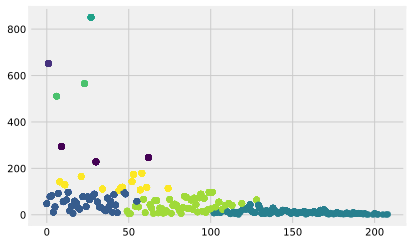

In [172]:
plt.scatter(train['DistrictId'],  train['SizeDistr'], c=labels_train)

In [160]:
# plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_train)

In [161]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [165]:
from sklearn.model_selection import GridSearchCV

parameters = [{'n_estimators': [150, 200, 250], 
               'max_features': np.arange(5, 9),
               'max_depth': np.arange(5, 10)}]

clf = GridSearchCV(estimator=RFR(random_state=22), 
                   param_grid=parameters,
                   scoring='r2',
                   cv=5)

clf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=22, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [150, 200, 250], 'max_features': array([5, 6, 7, 8]), 'max_depth': array([5, 6, 7, 8, 9])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=0)

In [173]:
clf.best_params_

{'max_depth': 9, 'max_features': 6, 'n_estimators': 200}

In [174]:
model_rfr  = RFR(max_depth=9, max_features=6, n_estimators=250, random_state=22)

In [175]:
# 1я модель - на объектах из Кластера 0
mod = model_rfr 
res_pred = pd.DataFrame()
for cluster in range(clasters):
    mod.fit(X_train.loc[labels_train==cluster, :],
            y_train[labels_train==cluster])
    y_valid_pred = mod.predict(X_valid.loc[labels_test==cluster, :])
    res_pred = res_pred.append(pd.DataFrame({'y_valid': y_valid[labels_test==cluster],
                               'y_pred': y_valid_pred.flatten()}, columns=['y_valid', 'y_pred']))
    print(f'{r2(y_valid[labels_test==cluster], y_valid_pred)}\n')
    

0.6286085919863393

0.7080329699586722

0.6272097897771605

0.5032863181745938

0.7566090381376476

0.8699623354434534

0.6876018437750225

0.6966677643542571



In [163]:
res_pred.head()

,y_valid,y_pred
2077,113252.747810,114973.563894
7099,65410.074769,71975.458210
779,136537.147348,145892.761985
1729,122922.189564,132630.466141
3233,111490.442726,128249.285158


In [164]:
# R2 по всем объектам тестовой выборки
r2(res_pred['y_valid'], res_pred['y_pred'])

0.7101839300202359

#### RandomForest для одного клатера

In [102]:
X_train = train.loc[train['DistrictId'] == 27,cols_for_scale]
y_train = train.loc[train['DistrictId'] == 27,'Price']#train_scaled_price['Price']

X_valid = valid.loc[valid['DistrictId'] == 27,cols_for_scale]
y_valid = valid.loc[valid['DistrictId'] == 27,'Price']#valid_scaled_price['Price']




# X_train = train_scaled_st.loc
# y_train = train_scaled_price['Price']

# X_valid = valid_scaled_st
# y_valid = valid_scaled_price['Price']

model_rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=9,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=250, n_jobs=None, oob_score=False, random_state=22,
           verbose=0, warm_start=False)

In [103]:
y_predict = model_rfr.predict(X_valid)
check_test = pd.DataFrame({'y_valid': y_valid, 
                           'y_predict': y_predict.flatten()}, columns=['y_valid', 'y_predict'])

In [104]:
check_test.shape

(268, 2)

In [105]:
check_test.head(10)

,y_valid,y_predict
9479,147475.061970,140777.594540
2176,151229.117658,139330.902338
5245,127291.380338,133665.126923
3170,182642.355518,162391.253383
5278,145057.208975,141960.238839
1884,67343.133878,197716.773125
3014,99838.186877,110177.668504
4325,130190.643579,137637.728975
4641,195469.502016,190542.614585
835,104457.850907,115742.093043


##### Оценка результатов

In [106]:
from sklearn.metrics import r2_score as r2
r2(y_valid, y_predict)

0.7566090381376476

In [ ]:
mean_squared_error(res_pred['y_valid'], res_pred['y_pred'])

In [ ]:
train.loc[labels_train==4, :]

In [ ]:
train.loc[labels_train==0, :]

#####  Выберем все данные с коректными данными

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

Отсечем экстремальные значения

In [ ]:
data_train.loc[data_train['Square'] > 200 ,:]

In [ ]:
plt.scatter(data_train['Rooms'],data_train['Square'])
plt.title('График №2 Диаграмма рассеяния (Диаграмма разброса, Scatter Plot)', fontsize=10)
plt.show()

In [ ]:
# data_train = data_train.drop(data_train.loc[data_train['Square']>200,:].index)

In [ ]:
train.loc[train['DistrictId'] == 27,:]

In [ ]:
data_train['DistrictId'].value_counts()

In [ ]:
data_train['HouseYear'].value_counts()

In [ ]:
data_train.loc[data_train['HouseYear'] > 100,:]

In [ ]:
data_train['HouseFloor'].value_counts()

In [ ]:
data_train['DistrFlat'] = 

In [ ]:
data_train.loc[data_train['HouseFloor'] == 117,'HouseFloor'] = 17